https://probflow.readthedocs.io/en/stable/examples/time_to_event.html

2024-04-15 10:59:05.223296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


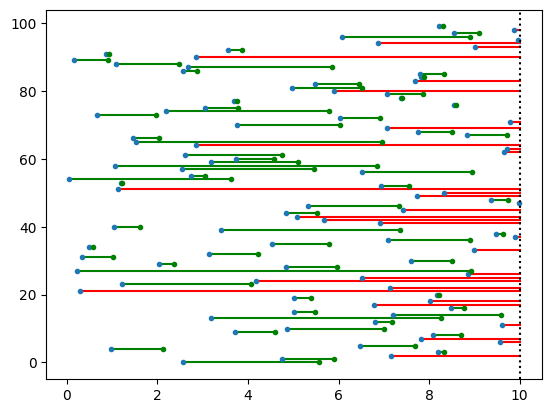

In [1]:
# Imports
import probflow as pf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
randn = lambda *x: np.random.randn(*x).astype('float32')

# Generate time-to-event data
N = 100 #number of customers
D = 2   #number of predictors
x = randn(N, D)
w = np.array([[1.], [-1.]]).astype('float32')
b = randn(1, 1)
y = tfd.Exponential(tf.nn.softplus(x@w + b)).sample().numpy()

# Simulate purchase times
t_stop = 10 #time of data collection
t1 = t_stop*np.random.rand(N)
t2 = t1 + y[:, 0]
cix = t2>t_stop
cid = np.arange(N) #customer id

# Plot em
plt.plot(np.row_stack((t1[~cix], t2[~cix])),
         np.row_stack((cid, cid))[:, ~cix], 'g')
plt.plot(np.row_stack((t1[cix], t_stop+0*t2[cix])),
         np.row_stack((cid, cid))[:, cix], 'r')
plt.plot(t1, cid, '.')
plt.plot(t2[~cix], cid[~cix], 'g.')
plt.axvline(t_stop, color='k', linestyle=':')

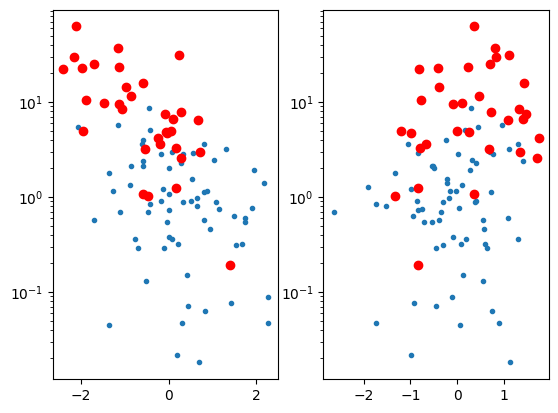

In [2]:
# Plot the data
for d in range(D):
    plt.subplot(1, 2, d+1)
    plt.plot(x[:, d], y, '.')
    plt.plot(x[cix, d], y[cix], 'ro')
    plt.yscale('log')

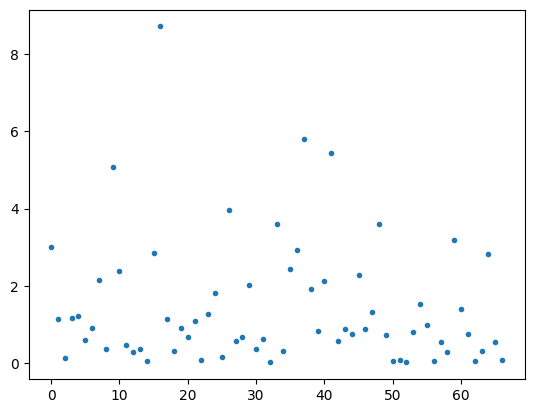

In [3]:
# Use only datapoints which were observed
y_train = y[~cix, :]
x_train = x[~cix, :]

# Plot em
plt.plot(y_train, '.')

In [4]:
class RegularSurvivalModel(pf.ContinuousModel):

    def __init__(self, d):
        self.layer = pf.Dense(d)

    def __call__(self, x):
        return tfd.Exponential(tf.nn.softplus(self.layer(x)))

In [5]:
model1 = RegularSurvivalModel(D)

In [6]:
model1.fit(x_train, y_train, lr=0.02, epochs=1000)

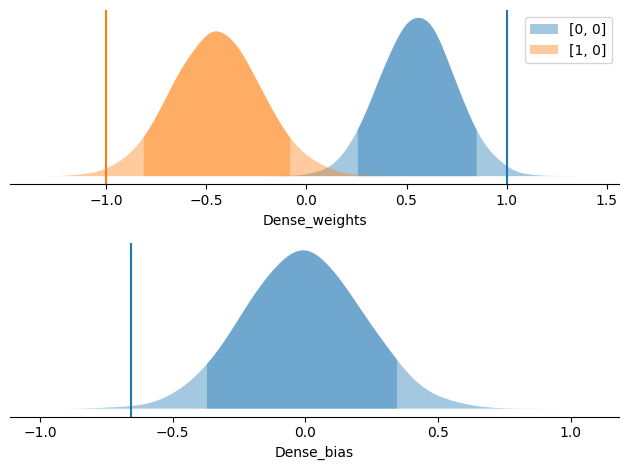

In [7]:
# Show model posteriors
model1.posterior_plot(ci=0.9)

# True parameter values
plt.subplot(2, 1, 1)
plt.axvline(w[0], color='C0')
plt.axvline(w[1], color='C1')
plt.subplot(2, 1, 2)
plt.axvline(b, color='C0')

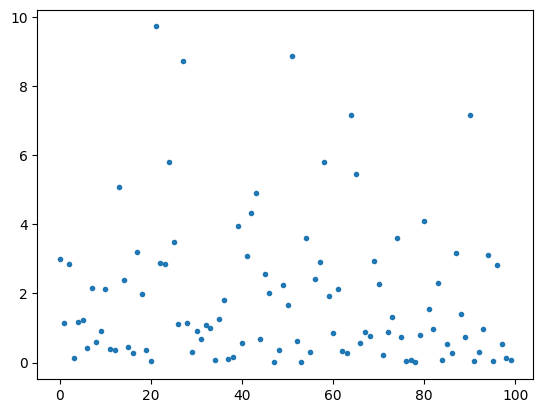

In [8]:
# Set nonobserved datapoints to time waiting
x_train = x
y_train = y.copy()
y_train[cix, 0] = t_stop-t1[cix]

# Plot em
plt.plot(y_train, '.')

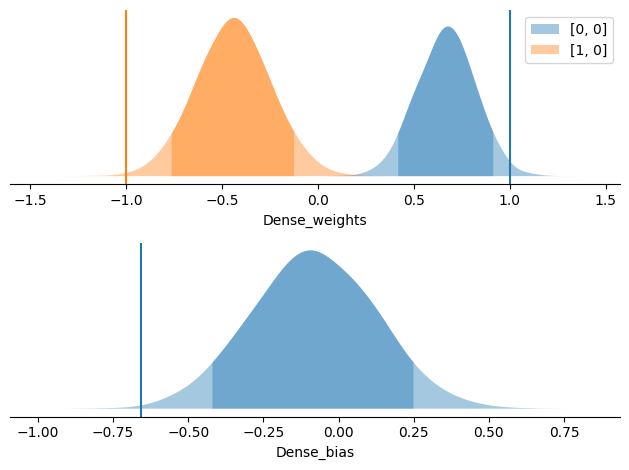

In [9]:
# Instantiate and fit a new model
model = RegularSurvivalModel(D)
model.fit(x_train, y_train, lr=0.02, epochs=1000)

# Show model posteriors
model.posterior_plot(ci=0.9)

# True parameter values
plt.subplot(2, 1, 1)
plt.axvline(w[0], color='C0')
plt.axvline(w[1], color='C1')
plt.subplot(2, 1, 2)
plt.axvline(b, color='C0')

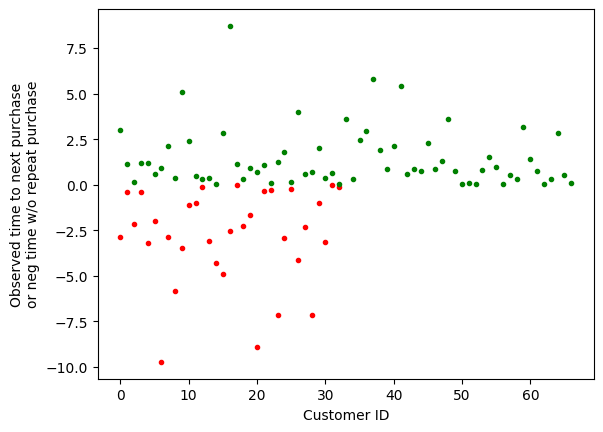

In [10]:
# Use all the data!
x_train = x
y_train = y.copy()

# Neg. wait time w/ still no observation
y_train[cix, 0] = t1[cix]-t_stop

# Plot it
plt.plot(y_train[cix], 'r.')
plt.plot(y_train[~cix], 'g.')
plt.xlabel('Customer ID')
plt.ylabel('Observed time to next purchase\n'
           'or neg time w/o repeat purchase')
plt.show()

In [11]:
class CensoredSurvivalModel(pf.ContinuousModel):

    def __init__(self, d):
        self.layer = pf.Dense(d)

    def __call__(self, x):
        return tfd.Exponential(tf.nn.softplus(self.layer(x)))

    def log_likelihood(self, x, y):
        """If y>=0, that's the time to the observed event.
        If y<0, it has not yet been observed after -y time!"""

        # Predicted distributions
        dist = self(x)

        # Likelihoods of observed time-to-events
        obs_ll = dist.log_prob(y)[y>=0]

        # Likelihoods of events not yet observed
        non_ll = dist.log_survival_function(-y)[y<0]

        # Return the sum of log likelihoods
        return tf.reduce_sum(obs_ll) + tf.reduce_sum(non_ll)

In [12]:
model2 = CensoredSurvivalModel(D)

In [13]:
model2.fit(x_train, y_train, lr=0.02, epochs=1000)

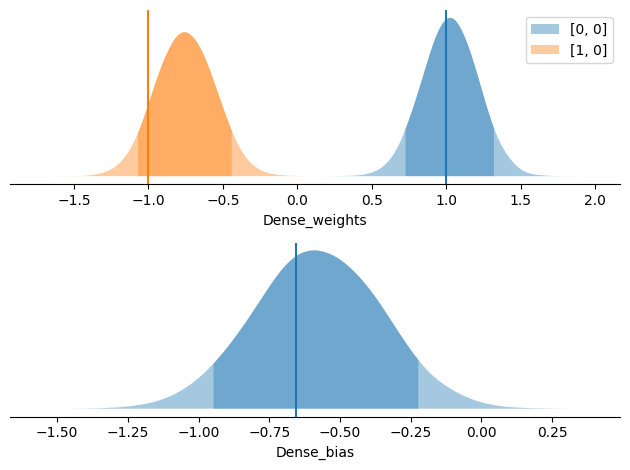

In [14]:
# Show model posteriors
model2.posterior_plot(ci=0.9)

# True parameter values
plt.subplot(2, 1, 1)
plt.axvline(w[0], color='C0')
plt.axvline(w[1], color='C1')
plt.subplot(2, 1, 2)
plt.axvline(b, color='C0')

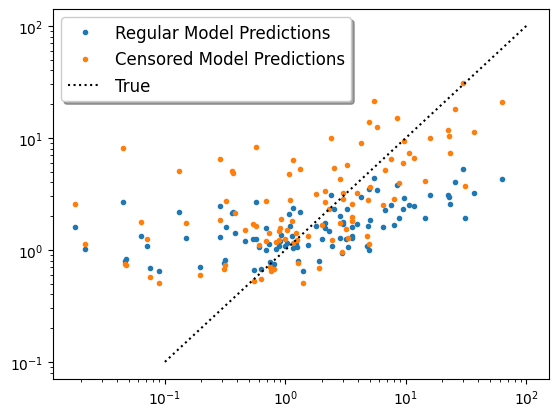

In [25]:
# Make predictions with both models
y_pred1 = model1.predict(x)
y_pred2 = model2.predict(x)

# Compare predictions from two models
plt.plot(y, y_pred1, '.', label='Regular Model Predictions')
plt.plot(y, y_pred2, '.', label='Censored Model Predictions')
plt.plot([0.1, 100], [0.1, 100], 'k:', label='True')
plt.xscale('log')
plt.yscale('log')

plt.legend(loc='upper left', shadow=True, fontsize='large')


In [16]:
class DeepSurvivalModel(pf.ContinuousModel):

    def __init__(self, dims):
        self.net = pf.DenseNetwork(dims)

    def __call__(self, x):
        return tfd.Exponential(tf.nn.softplus(self.net(x)))

    def log_likelihood(self, x, y):
        """Same as before"""
        dist = self(x)
        obs_ll = dist.log_prob(y)[y>=0]
        non_ll = dist.log_survival_function(-y)[y<0]
        return tf.reduce_sum(obs_ll) + tf.reduce_sum(non_ll)

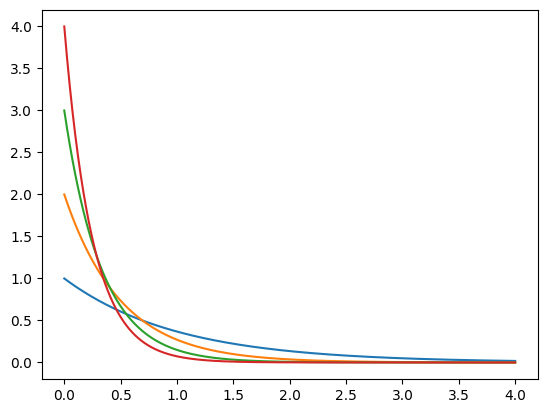

In [17]:
# Plot some Exponential distributions
xx = np.linspace(0, 4, 500)
for p in [1, 2, 3, 4]:
    plt.plot(xx, tfd.Exponential(p).prob(xx))

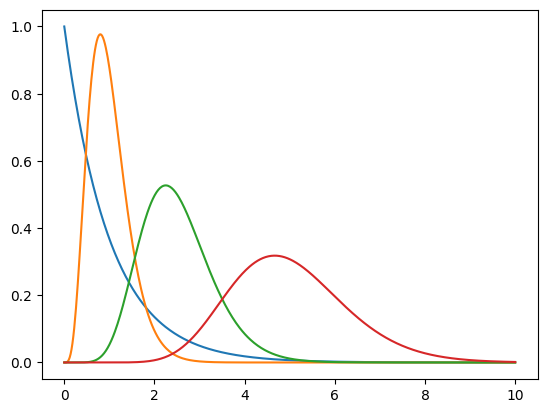

In [18]:
# Plot some Gamma distributions
xx = np.linspace(0, 10, 500)
for p in [[1, 1], [5, 5], [10, 4], [15, 3]]:
    plt.plot(xx, tfd.Gamma(*p).prob(xx))

In [19]:
class DeepSurvivalModel(pf.ContinuousModel):

    def __init__(self, dims):
        self.a_net = pf.DenseNetwork(dims) #net to predict alpha
        self.b_net = pf.DenseNetwork(dims) #net to predict beta

    def __call__(self, x):
        a = tf.nn.softplus(self.a_net(x))
        b = tf.nn.softplus(self.b_net(x))
        return tfd.Gamma(a, b)

    def log_likelihood(self, x, y):
        """If y>=0, that's the time to the observed event.
        If y<0, it has not yet been observed after -y time!"""

        def grad_safe_indexed_gamma_lp(x, y, lp_fn, ix_fn, min_lp=-100):
            a = tf.nn.softplus(self.a_net(x))
            b = tf.nn.softplus(self.b_net(x))
            ix = ix_fn(y[:, 0]) #indexes to use (observed vs not)
            y_ix = tf.boolean_mask(y, ix, axis=0)
            a_ix = tf.boolean_mask(a, ix, axis=0)
            b_ix = tf.boolean_mask(b, ix, axis=0)
            lp = lp_fn(tfd.Gamma(a_ix, b_ix), y_ix)
            safe = lp[:, 0]>min_lp #indexes with "safe" log probs
            y_safe = tf.boolean_mask(y_ix, safe, axis=0)
            a_safe = tf.boolean_mask(a_ix, safe, axis=0)
            b_safe = tf.boolean_mask(b_ix, safe, axis=0)
            return lp_fn(tfd.Gamma(a_safe, b_safe), y_safe)

        # Likelihoods of observed datapoints
        obs_ll = grad_safe_indexed_gamma_lp(x, y,
            lambda dist, y: dist.log_prob(y),
            lambda y: y>=0)

        # Likelihoods of datapoints which were not observed
        non_ll = grad_safe_indexed_gamma_lp(x, y,
            lambda dist, y: dist.log_survival_function(-y),
            lambda y: y<0)

        # Return the sum of log likelihoods
        return tf.reduce_sum(obs_ll) + tf.reduce_sum(non_ll)

In [20]:
model = DeepSurvivalModel([D, 1])